## 1

In [1]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 37.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# we will use these later for the CNN
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [5]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            #transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True), #for enable data augmnentation
            #transforms.RandomHorizontalFlip(), #for enable data augmnentation
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self): # For data documentation, and create batches
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True, #optimization id we're using GPU
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [6]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

In [7]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

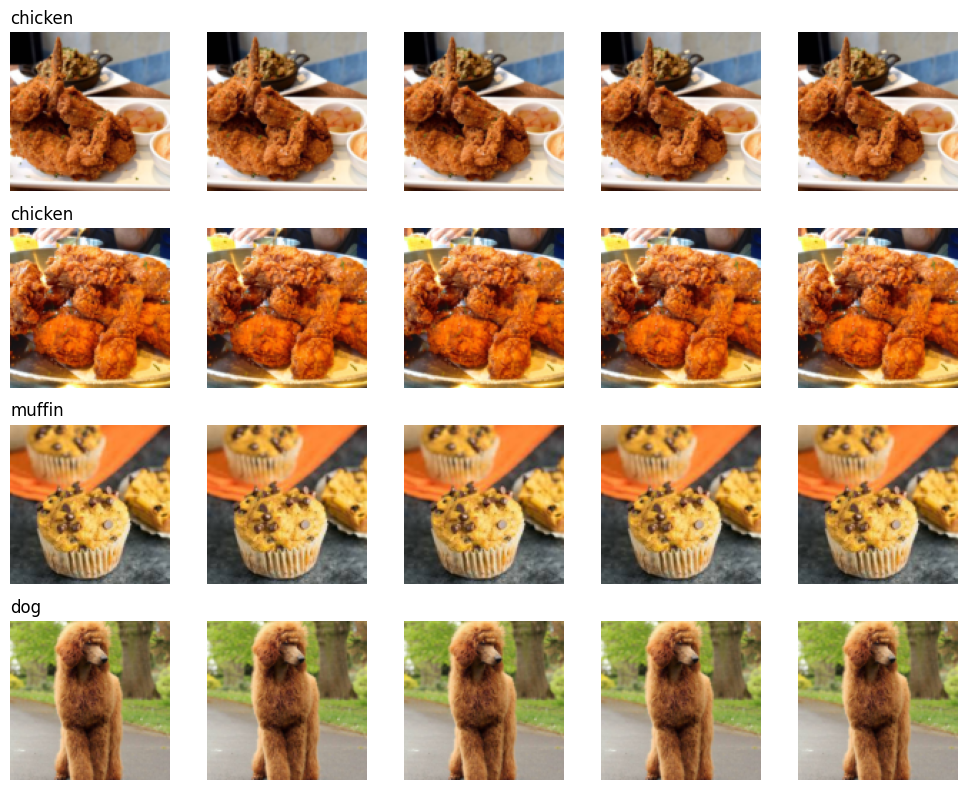

In [8]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

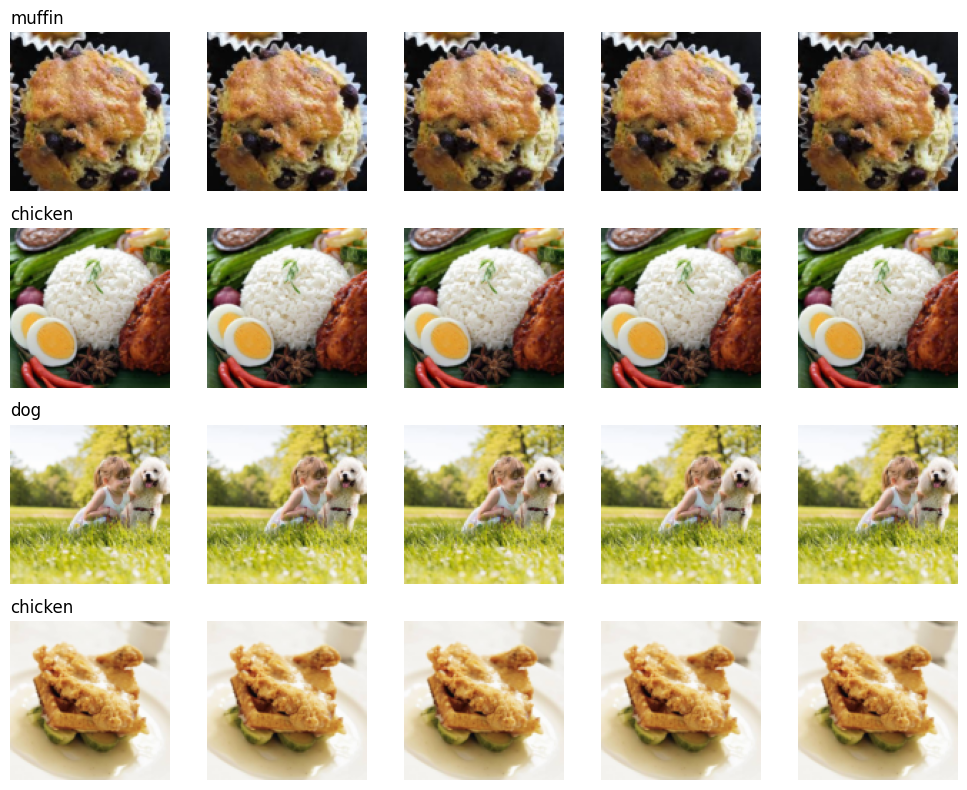

In [9]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

Classifier Model Definition

In [10]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"]) #BINARY CROSS ENTROPY FOR BINARY CLASS
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay) #Self.parameters update all the parameters of the model, all the layers
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay) #regularization(weight)

Convolutional Neural Network Definiton

In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),#in channels = 3 means RGB
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# If we comment the ReLU code the performance will drop and will be a simple linear

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)
  # for param...

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [12]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

Training

In [13]:
# Put it on the Weights and biases  platform
wandb_logger = pl.loggers.WandbLogger(project="first_exp", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed", #mixed precission, make the neural network faster
    accelerator="gpu",
    devices=1,
    logger=wandb_logger, #don't forget to call in
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: acuadrosrivas (alecuadrosrivas). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 112 K 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.451     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc_epoch,▁▄▅▅▆▇████
train_acc_step,▄▁▂▁▃▅▅▃▇▅▄█▆▇
train_loss_epoch,█▅▅▄▄▃▂▂▁▁
train_loss_step,▆▆█▇▆▄▃█▂▅▄▁▃▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▂▃▄▅▆▅▆█▄
val_loss,█▇▆▅▄▂▃▂▁▆
epoch,9
train_acc_epoch,0.69911
train_acc_step,0.78125


In [14]:
wandb.finish()

Tasks (during practice, solved together)
Visualize the augmented/preprocessed training/validation images. What do we see?
Turn image augmentations off in the training transforms.
Inspect the baseline CNN. What are the output shapes after each layer?
Run the baseline training.
Remove all ReLUs from our convolutional network. What do we expect? What do we see?
Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)?
Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).
Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.
Warning 1: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
Warning 2: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.
Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?

-> Transfer Learning

- Effects on data augmentation and how it impacts on performance
- Replace the CNN with a MobilenetV2 network.
- Effects of overfitting, the validation loss goes up and validation acc goes up.
- Transfer the parameters and addapt it to the new domain.

1. code
2. #model = torchvision.models.mobilenet_v2(num_classes=num_classes)
3. #model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2") **after running this one we remove the Linear layer  from the classifier layer** #model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

 - just update the last classifier layer.

# 2

In [15]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True), #for enable data augmnentation
            transforms.RandomHorizontalFlip(), #for enable data augmnentation
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self): # For data documentation, and create batches
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True, #optimization id we're using GPU
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [16]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

In [17]:
# model = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),#in channels = 3 means RGB
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.AdaptiveAvgPool2d(output_size=1),
#     torch.nn.Flatten(),
#     torch.nn.Linear(in_features=width, out_features=num_classes),
# )

# If we comment the ReLU code the performance will drop and will be a simple linear

model_2 = torchvision.models.mobilenet_v2(num_classes=num_classes)
  # for param in model.parameters()
  #     param.requires_grad = False

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model_2)
print(model_2(torch.randn(batch_size, 3, resolution, resolution)).shape)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [18]:
# model = torch.compile(model)
lit_model_2 = ImageClassifier(model_2)

In [19]:
# Put it on the Weights and biases  platform
wandb_logger = pl.loggers.WandbLogger(project="second_exp", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed", #mixed precission, make the neural network faster
    accelerator="gpu",
    devices=1,
    logger=wandb_logger, #don't forget to call in
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model_2, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | MobileNetV2        | 2.2 M 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.911     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▄▅▅▆▆▆▇▇▇█▇█
train_acc_step,▁▄▃▅▄▅▃▁▆▅▂▄█▄▆▇▆▄▅
train_loss_epoch,█▅▅▅▄▃▃▃▂▂▂▂▁
train_loss_step,█▄▆▅▆▅█▇▂▃▇▅▂▅▂▁▃▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▅▆▆▇▇▇▇█▇███
val_loss,█▃▂▂▂▁▂▁▁▂▁▁▁
epoch,13
train_acc_epoch,0.80223
train_acc_step,0.8125


In [20]:
wandb.finish()

Use the pretrained model when we work with data
We just updated the last layer.

# 3

In [21]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True), #for enable data augmnentation
            transforms.RandomHorizontalFlip(), #for enable data augmnentation
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self): # For data documentation, and create batches
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True, #optimization id we're using GPU
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [22]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

In [23]:
# model = torch.nn.Sequential(
#     torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),#in channels = 3 means RGB
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.AdaptiveAvgPool2d(output_size=1),
#     torch.nn.Flatten(),
#     torch.nn.Linear(in_features=width, out_features=num_classes),
# )

# If we comment the ReLU code the performance will drop and will be a simple linear

#model = torchvision.models.mobilenet_v2(num_classes=num_classes)
  # for param in model.parameters()
  #     param.requires_grad = False

model_3 = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
model_3.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model_3)
print(model_3(torch.randn(batch_size, 3, resolution, resolution)).shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

  6%|▌         | 848k/13.6M [00:00<00:01, 8.68MB/s]

 33%|███▎      | 4.53M/13.6M [00:00<00:00, 26.4MB/s]

100%|██████████| 13.6M/13.6M [00:00<00:00, 44.9MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [24]:
# model = torch.compile(model)
lit_model_3 = ImageClassifier(model_3)

In [25]:
# Put it on the Weights and biases  platform
wandb_logger = pl.loggers.WandbLogger(project="third_exp", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed", #mixed precission, make the neural network faster
    accelerator="gpu",
    devices=1,
    logger=wandb_logger, #don't forget to call in
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model_3, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | MobileNetV2        | 2.2 M 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.911     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇██
train_acc_epoch,▁▇▆▇▇█▇██
train_acc_step,▁▆▅██▆█▆██████
train_loss_epoch,█▂▃▂▁▁▂▁▁
train_loss_step,█▄▄▃▂▃▁▃▁▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
val_acc,▁▅▃▇▂▃▃█▆
val_loss,█▄▄▃▃▂▃▁▁
epoch,9
train_acc_epoch,0.98438
train_acc_step,1.0


In [26]:
wandb.finish()

# **Tasks (during practice, solved together)**

**1.	Visualize the augmented/preprocessed training/validation images. What do we see?**
The augmented images display varied rotations, flips, crops, and scales, introducing visual diversity to help the model generalize better from the training data.

**2.	Turn image augmentations off in the training transforms.**


**3.	Inspect the baseline CNN. What are the output shapes after each layer?**
The output shapes after each layer in the baseline CNN reflect the transformations of the input data as it passes through convolutions, activations, pooling, and fully connected layers, reducing in spatial dimensions while potentially increasing in depth corresponding to feature maps.

**4.	Run the baseline training.**


**5.	Remove all ReLUs from our convolutional network. What do we expect? What do we see?**
Removing all ReLU activations from a convolutional network produce a loss of non-linearity, which may lead to poorer performance as the model cannot capture complex patterns in the data.

**6.	Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)?**

When replacing the CNN with a MobileNetV2 network, it's expected improved performance due to MobileNetV2's efficient architecture designed for mobile devices, which offers a good balance between speed and accuracy.

**7.	Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).**

**8.	Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.**
- Warning 1: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
- Warning 2: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.

**9.	Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?**


# **Tasks (homework)**
Your tasks are the following:


## **1.**
**Add some other type of image augmentation to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.**

In [27]:
# Let's add ColorJitter and RandomRotation Augmentation, so we update the code

class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self): # For data documentation, and create batches
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True, #optimization id we're using GPU
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()


In [28]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

In [29]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

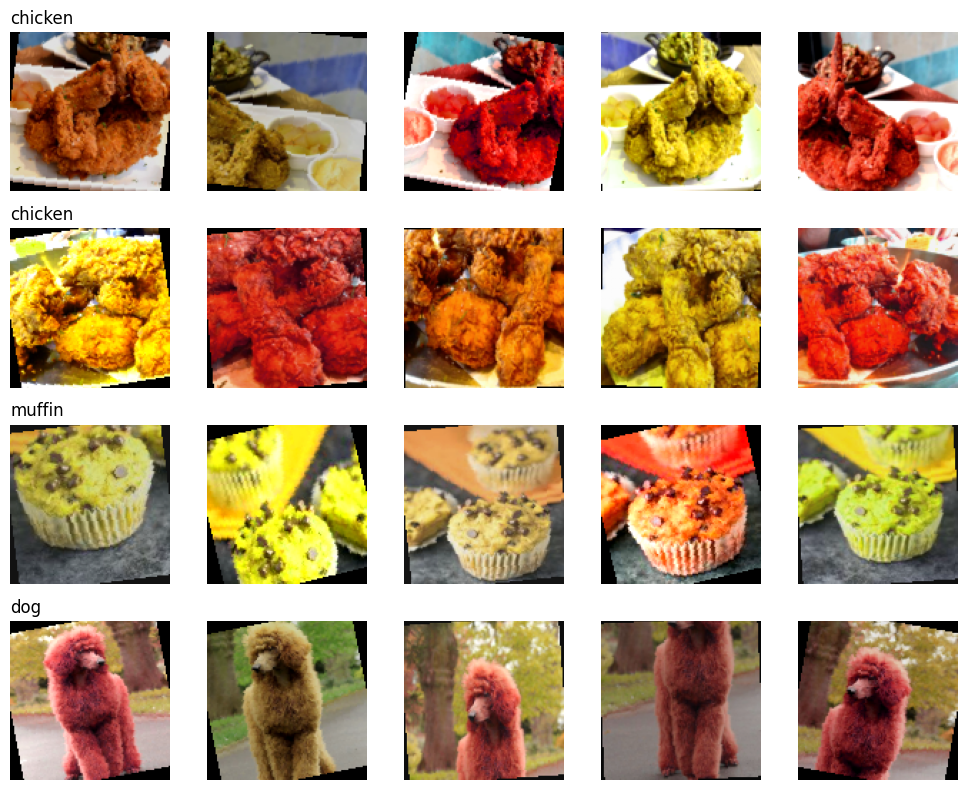

In [30]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

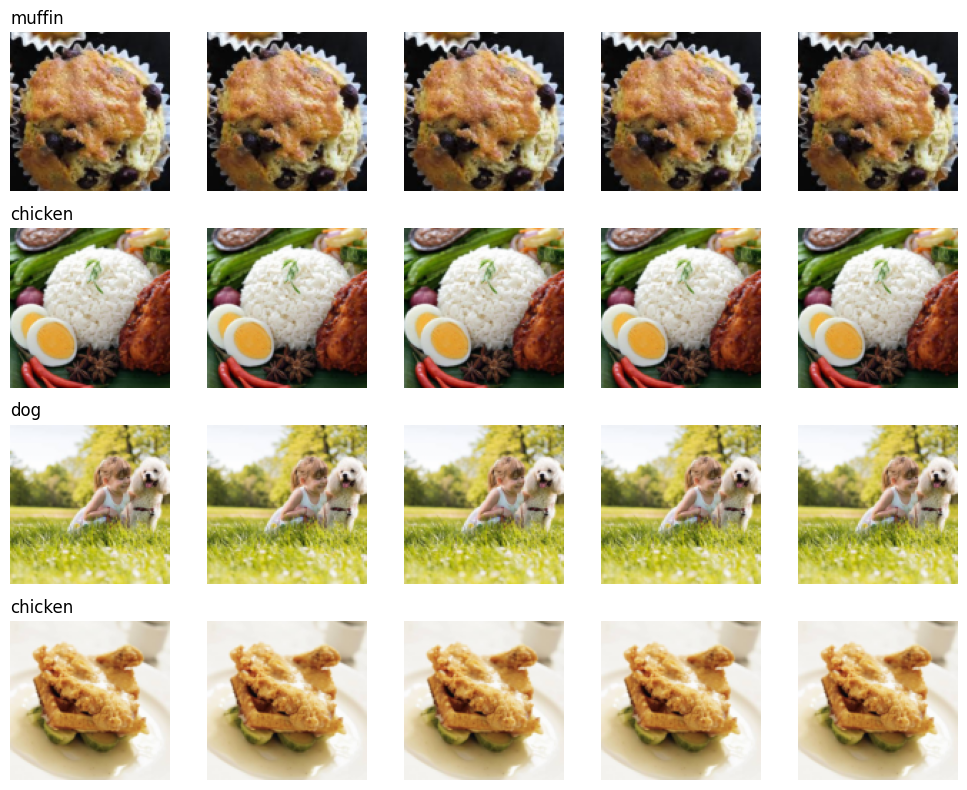

In [31]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

In [32]:
def visualize_images(dataset, num_images=4, num_augmentations=5):
    for i in range(num_images):
        image = dataset[i]['image']

        for j in range(num_augmentations):
            augmented_image = augment_image(image)
            plt.imshow(augmented_image.numpy().transpose(1, 2, 0))
            plt.axis('off')

            # Save each augmented image
            plt.savefig(f'augmented_image_{i}_{j}.png', bbox_inches='tight', pad_inches=0)
            plt.close()

## **2.**
**Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!**

In [33]:
width = 64
num_classes = 3

In [34]:
# Exact number of parameters in the original network:
model.parameters = sum(p.numel() for p in model.parameters())
model.parameters

112771

In [81]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model_new_network):
        super().__init__()
        self.model_new_network = model_new_network
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model_new_network(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"]) #BINARY CROSS ENTROPY FOR BINARY CLASS
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay) #Self.parameters update all the parameters of the model, all the layers
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay) #regularization(weight)

In [36]:
model_new_network = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

print(model_new_network)
print(model_new_network(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [37]:
# Exact number of parameters in the new network:
model_new_network.parameters = sum(p.numel() for p in model_new_network.parameters())
model_new_network.parameters

113283

## **3.**
**Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.**

In [87]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model_new_network):
        super().__init__()
        self.model_new_network = model_new_network
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task="multiclass")

    def forward(self, x):
        return self.model_new_network(x)

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        labels = batch["label"]
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch["image"] #
        labels = batch["label"] #
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        self.confusion_matrix.update(pred_labels, labels) ###
        return loss

    def test_step(self, batch, batch_idx):
        images = batch["image"]
        labels = batch["label"]
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        self.confusion_matrix.update(pred_labels, labels) ###
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

In [88]:
model_new_network = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

print(model_new_network)
print(model_new_network(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [89]:
# model_new_network = torch.compile(model)
lit_model_new_network = ImageClassifier(model_new_network)

**TRAINING**

In [90]:
wandb_logger = pl.loggers.WandbLogger(project="Confusion Matrix", log_model="all")
lit_model_new_network = ImageClassifier(model_new_network)
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision=16,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model_new_network, datamodule)
trainer.test(lit_model_new_network, datamodule)

conf_matrix = lit_model_new_network.confusion_matrix.compute()
print("Confusion Matrix: \n", conf_matrix)

wandb.log({"confusion_matrix": wandb.Image(plt)})

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                      | Params
----------------------------------------------------------------
0 | model_new_network | Sequential                | 113 K 
1 | accuracy          | MulticlassAccuracy        | 0     
2 | confusion_matrix  | MulticlassConfusionMatrix | 0     
----------------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.871999979019165     │
│         test_loss         │    0.3271971344947815     │
└───────────────────────────┴───────────────────────────┘

Confusion Matrix: 
 tensor([[6160,  282,  676],
        [ 769, 6372,  791],
        [ 808,  467, 6989]])


<Figure size 640x480 with 0 Axes>

- The first row indicates that 6160 instances of class 0 were correctly predicted as class 0 (true positives for class 0). However, 282 instances of class 0 were incorrectly predicted as class 1, and 676 instances of class 0 were incorrectly predicted as class 2.
- The second row shows that 6372 instances of class 1 were correctly predicted as class 1 (true positives for class 1), but there were 769 false negatives where class 1 was predicted as class 0, and 791 false negatives where class 1 was predicted as class 2.
- The third row shows that 6989 instances of class 2 were correctly predicted as class 2 (true positives for class 2), with 808 instances incorrectly predicted as class 0 and 467 instances as class 1.